In [1]:
# install pygame
# pip install pygame

# install ple
# git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# cd PyGame-Learning-Environment/
# pip install -e .

# install gym_ple
# pip install gym_ple

In [1]:
%matplotlib inline
import time
 
import gym
import gym_ple
import matplotlib
from matplotlib.pyplot import imshow, show
from collections import deque, namedtuple
import numpy as np
# from skimage import color, transform

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
env = gym.make('FlappyBird-v0').unwrapped


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom
WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


In [2]:
env.action_space, env.observation_space

(Discrete(2), Box(512, 288, 3))

In [3]:
state = env.reset()
state.shape

(512, 288, 3)

In [4]:
state = env.reset()


0.0 False


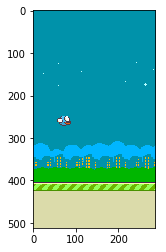

In [5]:
state, reward, done, _ = env.step(1)
print(reward,done)
imshow(state)

In [6]:
transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(),
                       T.Resize((80,45)),
                       T.ToTensor()])

toPIL = T.ToPILImage()

def preprocess_frame(frame):
    new_frame = frame[:400, 40:]

    return transform(new_frame)

In [7]:
# def preprocess_frame(frame):
    
#     cropped = frame[:400, 40:]
#     gray = color.rgb2gray(cropped)
#     normalized = gray/255.0
    
#     resized = transform.resize(normalized, (80, 45))
    
#     return resized

In [8]:
t= preprocess_frame(next_state)
print(t.size())
toPIL(t)

NameError: name 'next_state' is not defined

In [9]:
tt=[t,t,t,t]
torch.cat(tt, dim=0).size()

NameError: name 't' is not defined

In [10]:
stack_size = 4
stacked_frame = deque([torch.zeros((1, 80, 45), dtype=torch.float32) for i in range(stack_size)])


In [11]:
stack_size = 5

stacked_frames = deque([torch.zeros((1, 80, 45), dtype=torch.float32) for i in range(stack_size)])

def stack_frames(stacked_frames, state, new_episode= True):
    processed_state = preprocess_frame(state)
    if new_episode:
        for i in range(stack_size):
            stacked_frames.append(processed_state)
    else:
        stacked_frames.append(processed_state)
    stacked = torch.cat(stack_frames, dim=0)
    return stacked_state, stacked_frames 

In [12]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x.view(x.size(0), -1))
        return self.fc2(x)

In [8]:
# x = torch.zeros([1,4,84,84], device=device)
# dqn = DQN().to(device)
# pred = dqn.forward(x)
# pred

tensor([[-0.0418, -0.0134]], device='cuda:0', grad_fn=<ThAddmmBackward>)

In [9]:
torch.cat([x,x]).shape

torch.Size([2, 4, 84, 84])

In [10]:
pred.max(1)[1].item().dtype

AttributeError: 'int' object has no attribute 'dtype'

In [ ]:
t = torch.rand([10,2])
t

In [ ]:
tt = torch.tensor(np.random.randint(2, size=10))

In [11]:
torch.gather(t,index=tt,dim=1)

NameError: name 't' is not defined

In [13]:
class Memory(object):
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
    def add(self, experience):
        self.buffer.append(experience)
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(range(buffer_size),
                                size = batch_size,
                                replace = False)
        return [self.buffer[i] for i in index]
    def __len__(self):
        return len(self.buffer)

In [16]:
class Agent(object):
    def __init__(self):
        self.env = gym.make('FlappyBird-v0').unwrapped
        self.dqn = DQN().to(device)
        self.optimizer = optim.RMSprop(self.dqn.parameters())
        
        self.memory = Memory(100000)
        self.gamma = 0.9
        self.epsilon_start = 0.1
        self.epsilon_decay = 0.001
        self.epsilon_stop = 0.01
        self.batch_size = 32
        self.max_step = 1000
        
        self.transform = T.Compose([T.ToPILImage(),
                                       T.Grayscale(),
                                       T.Resize((84,84)),
                                       T.ToTensor()])
        self.stack_size = 4
        self.stacked_frames = deque([torch.zeros((1, 84, 84), dtype=torch.float) for i in range(self.stack_size)], maxlen=self.stack_size)
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))
    
    def preprocess_frame(self, frame):
        new_frame = frame[:400, 40:]
        return self.transform(new_frame).unsqueeze(0).to(device)
    
    def stack_frames(self, frame, new_episode= True):
        processed_state = self.preprocess_frame(frame)
        if new_episode:
            for i in range(self.stack_size):
                self.stacked_frames.append(processed_state)
        else:
            self.stacked_frames.append(processed_state)
        stacked = torch.cat(list(self.stacked_frames), dim=1)
        return stacked 

    def action(self, state, steps_done):
        eps = self.epsilon_stop + (self.epsilon_start - self.epsilon_stop) * np.exp(-self.epsilon_decay * steps_done)
        if np.random.uniform() <= eps:
            with torch.no_grad():
                return self.dqn.forward(state).max(1)[1].view(-1, 1), eps
        else:
            return torch.tensor(np.random.randint(2), device=device).view(-1,1), eps
        
        
    def create_memory(self):
        frame = self.env.reset()
        state = self.stack_frames(frame, True)
        rewards = []

        done = False
        steps_done = 0
        while not done or (steps_done >= self.max_step):   
            action, eps = self.action(state, steps_done)

            next_state, reward, done, _ = self.env.step(action.item())
            
            rewards.append(reward)
            
            next_state = self.stack_frames(next_state, False)

            self.memory.add(self.transition(state, action, next_state, reward, done))

            state = next_state
            steps_done += 1

            if done:
                next_state = torch.zeros_like(state)
                self.memory.add(self.transition(state, action, next_state, reward, done))
                
                print('Steps: {}'.format(steps_done),
                    'Total reward: {}'.format(np.sum(rewards)),
                      'Explore P: {:.4f}'.format(eps))
    
    def learn(self):
        frame = self.env.reset()
        state = self.stack_frames(frame, True)
        rewards = []

        done = False
        steps_done = 0
        while not done or (steps_done >= self.max_step):   
            action, eps = self.action(state, steps_done)

            next_state, reward, done, _ = self.env.step(action.item())
            
            rewards.append(reward)
            
            next_state = self.stack_frames(next_state, False)

            self.memory.add(self.transition(state, action, next_state, reward, done))

            state = next_state
            steps_done += 1

            if done:
                next_state = torch.zeros_like(state)
                self.memory.add(self.transition(state, action, next_state, reward, done))
                
                
                print('Steps: {}'.format(steps_done),
                    'Total reward: {}'.format(np.sum(rewards)),
                      'Explore P: {:.4f}'.format(eps),
                        'Loss: {}'.format(loss))
        
        
        ###############
        
            batch = self.memory.sample(self.batch_size)
    #         print(batch)
            states_mb = torch.cat([each.state for each in batch])
            actions_mb = torch.cat([each.action for each in batch])
            next_states_mb = torch.cat([each.next_state for each in batch])
            rewards_mb = [each.reward for each in batch]
            dones_mb = [each.done for each in batch]

            target_Qs_batch = []

             # Get Q values for next_state 
    #         Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
            Qs_next_state = self.dqn.forward(next_states_mb).max(1)[0].detach()
    #         print(Qs_next_state.size(), Qs_next_state.max())

    #         # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
            for i in range(len(batch)):
                terminal = dones_mb[i]

                # If we are in a terminal state, only equals reward
                if terminal:
                    target_Qs_batch.append(rewards_mb[i])

                else:
                    target = rewards_mb[i] + self.gamma * Qs_next_state[i]
                    target_Qs_batch.append(target)

            Qs_targets = torch.tensor(target_Qs_batch, device=device)
    #         print(actions_mb)
            Qs = self.dqn.forward(states_mb).gather(1, actions_mb)
    #         print(Qs)
    #         print(Qs.size(), Qs_targets.size())
            # Compute Huber loss
            loss = F.mse_loss(Qs, Qs_targets.unsqueeze(1))
#             print(loss.item())

    #         # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                
    def train(self, num_episodes=10000):
        while len(self.memory) <= self.batch_size:
            self.create_memory()
        
        for i in range(num_episodes):
#             self.create_memory()
            self.learn()
            

In [18]:
# agent_dqn = Agent()
# agent_dqn.train()

In [112]:
len(agent_dqn.memory.buffer)

71

In [150]:
t = torch.ones((3,3))
tt = deque([t,t,t])

In [179]:
t.unsqueeze(0).size()

torch.Size([1, 3, 3])

In [152]:
torch.cat(list(tt))

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [66]:
import random
torch.tensor([[np.random.randint(2)]], device=device, dtype=torch.long)

tensor([[0]], device='cuda:0')

In [137]:

torch.zeros_like(t)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [10]:
state = env.reset()

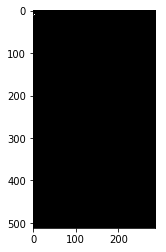

In [13]:
plt.imshow(state)

In [18]:
state = env.render(mode='rgb_array')

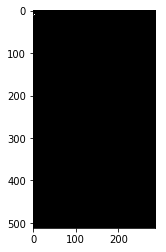

In [19]:
plt.imshow(state)

In [22]:
next_state = env.step(1)

In [ ]:
# next_state

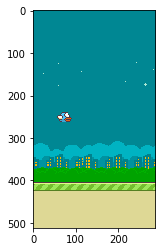

In [25]:
plt.imshow(next_state[0])

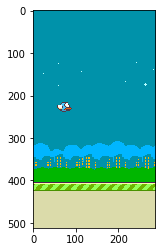

KeyboardInterrupt: 

In [14]:
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 100
reward = 0
done = False

for i in range(episode_count):
    ob = env.reset()

    while True:
        action = agent.act(ob, reward, done)

        ob, reward, done, _ = env.step(action)
        
#         print(ob)
        clear_output(wait=True)
        plt.imshow(ob)
        show()
        time.sleep(.1)
        
        if done:
            break
        # Note there's no env.render() here. But the environment still can open window and
        # render if asked by env.monitor: it calls env.render('rgb_array') to record video.
        # Video is not recorded every episode, see capped_cubic_video_schedule for details.


In [ ]:
# references
# https://github.com/AndersonJo/dqn-pytorch/blob/master/dqn.py